In [1]:
# TO-DO

# 1 Double check algorithms!
# 2 Double check index value calculators! (DB-index especially!!)
# 3 SCALE INPUT VARIABLES ??


# 3 TROUBLESHOOT ERRORS! XX
# 4 CENTROID CALCULATOR FUNCTION FOR MST XX

In [2]:
# Import some modules which we will use later

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import copy


%matplotlib inline

## Functions

In [40]:
# Define custom function

## Basic functions for all algorithms

def euclidean_dist(x,y):
    """Calculates Euclidean distance between 2 n-dimensional vectors"""
    temp = x-y
    temp_2 = temp**2
    temp_sum = sum(temp_2)
    temp_sqrt = math.sqrt(temp_sum)
    
    return temp_sqrt

def benchmark_data_generation(n,p,K,std):
    """Generates benchmak data for clustering"""

    from sklearn.datasets.samples_generator import make_blobs
    X, y = make_blobs(n_samples=n, centers=K, n_features = p,
                  random_state=0, cluster_std=std)
    
    return X, y

## Functions for the MST algorithm

def adjacency_matrix(X):
    """Calculates distance matrix of input data points"""
    n = X.shape[0]
    dist_matrix = np.zeros((n, n))
    for i in range(0,n):
        for j in range(i+1,n):
            dist_matrix[i,j]=euclidean_dist(np.array(X.iloc[i,]),np.array(X.iloc[j,]))
            
    return dist_matrix


def edge_vector(dist_matrix):
    """Creates list of edges/vertices with the corresponding distance"""
    n=len(dist_matrix)
    n_rows = int(n*(n-1)*(0.5))
    edge_dist = np.zeros((n_rows, 3))
    
    counter = 0
    
    for i in range(0,n):
        for j in range(i+1,n):
            
            edge_dist[counter,0] = i
            edge_dist[counter,1] = j
            edge_dist[counter,2] = dist_matrix[i,j]
            counter += 1
            
    return edge_dist

def edge_sorting(edge_vector):
    """Sorts the list of edges/distances"""
    sorted_matrix = edge_vector[edge_vector[:, -1].argsort()]
    
    return sorted_matrix


## Functions for MST/Kruskal algorithm
def mst_cluster(X, k, d):
    X = pd.DataFrame(X)
    #print("Shape of X: {}".format(X.shape))
    matrix = adjacency_matrix(X)
    vector = edge_vector(matrix)
    sorted_vector = edge_sorting(vector)
    #print("Shape of sorted_vector: {}".format(sorted_vector.shape))


    i = 0
    #initialize 1 cluster for each point
    points_set = X.join(pd.DataFrame(np.arange(0,len(X)), columns=['Cluster']))
    #print("Shape of point_set: {}".format(points_set.shape))
    #set stopping point
    while points_set['Cluster'].nunique() > k:
        #start from firs row or sorted vector, get nodes
        node1 = sorted_vector[i][0].astype('int')
        node2 = sorted_vector[i][1].astype('int')
        #identify to which cluster each point belongs
        cluster1 = points_set.iloc[node1,d]
        cluster2 = points_set.iloc[node2,d]
        #cluster1 = points_set.iloc[node1,2]
        #cluster2 = points_set.iloc[node2,2]
        #if they are from the same cluster already, no connection can be made to avoid cycle
        if cluster1 != cluster2:
            # if they are different, the smaller cluster label will be given to the larger
            if cluster1 < cluster2:
                #points_set.iloc[node2,2] = cluster1
                points_set.iloc[node2,d] = cluster1
            else:
                #points_set.iloc[node1,2] = cluster2
                points_set.iloc[node1,d] = cluster2
        i = i +1
        
    #points_set.drop(columns=[0,1])
    col_list = list(np.arange(0,d,1))
    #print(col_list)
    points_set.drop(columns=col_list)
    points_set['point_index'] = points_set.index
    points_set = points_set[['point_index', 'Cluster']]
    points_set = np.array(points_set)
    return points_set


def centroid_calc_for_mst(K,d,result,X):
    """Calculates the centroids of the clusters
    found by the MST method"""
    
    # Get current unique labels
    uniques = pd.DataFrame(result).iloc[:,1]
    uniques = uniques.unique()
    
    # Loop over the clusters table and assign cluster names
    # going from 0-15 (basically just renaming clusters for convenience)
    for i in range(0,len(result)):
        # Getting the current cluster label
        index = int(result[i,1]) 
        # Searching the current cluster label in the list of unique labels
        unique_places = np.array([i==index for i in uniques])

        # Assign the relative location of the current label to the range of 0-15
        temp = np.where(unique_places)[0]
        result[i,1] = temp

    # Initialize the centroids to be 0
    centroids2 = np.zeros((K, d))

    for i in range(0,K):
                # Filter for points in the given cluster
                temp_table2 = result[result[:,1]==i]

                # Calculating new centroids
                temp_array = np.zeros((len(temp_table2),d))
                counter = 0
                


                for j in temp_table2[:,0]:
 
                    temp_array[counter,:] = X[j,:]
                    counter += 1

                # Assign the new centroids - coordinate-wise mean of points in the cluster
                centroids2[i,:] = np.mean(temp_array, axis=0)

    return centroids2

## Functions for the k-means algorithms

def k_means_clustering(K,X):
    n = X.shape[0] # Number of observations
    d = X.shape[1] # dimensions
    X = np.array(X) # Convert pandas dataframe to numpy array

    # STEP 0
    # Get initial starting points
    initial_indices = np.random.randint(0,high=n,size=K) # Initial indices
    print(initial_indices)

    centroids = np.zeros((K, d))

    counter = 0
    for i in initial_indices:
        centroids[counter,:] = X[i,:]
        counter += 1

    #print(centroids)

    # STEP 1
    # Assign points to centroids
    cluster_table = np.zeros((n, 2))
    cluster_table[:,0] = np.arange(0,n,1)
    cluster_table = cluster_table.astype(int)
    
    
    change_tracker = True
    
    cost_values_db = []
    cost_values_dunn = []
    # Big loop
    while change_tracker:
        overall_change = 0
        for i in range(0,n):
            current_cluster = int(cluster_table[i,1])
            #print(current_cluster)
            current_dist = euclidean_dist(X[i,],centroids[current_cluster,])
            for j in range(0,K):
                temp = euclidean_dist(X[i,],centroids[j,])
                if temp<current_dist:
                    cluster_table[i,1]=j
                    current_dist = temp

                    overall_change += 1

        if overall_change == 0:
            change_tracker = False

        # STEP 2
        # Recalculate centroids
        #print(cluster_table)

        # Filter observations
        temp_table = cluster_table[cluster_table[:,1]==0]
        #print(temp_table)

        for i in range(0,K):
            # Filter for points in the given cluster
            temp_table2 = cluster_table[cluster_table[:,1]==i]

            # Calculating new centroids
            temp_array = np.zeros((len(temp_table2),d))
            counter = 0

            for j in temp_table2[:,0]:
                temp_array[counter,:] = X[j,:]
                counter += 1

            # Assign the new centroids
            centroids[i,:] = np.mean(temp_array, axis=0)
            
        cost_values_db.append(DB_index(X,centroids,cluster_table))
        cost_values_dunn.append(dunn_index(X,centroids,cluster_table))
            
    return centroids,cluster_table,cost_values_db,cost_values_dunn

## Functions for the Davies-Boulding-index

# Within cluster distances
def within_cluster_dist(X,centroids,cluster_table):
    sums = []
    for i in range(0,len(centroids)):
        temp = cluster_table[cluster_table[:,1]==i]
        temp_sum = 0
        if len(temp)!=0:
            for j in range(0,len(temp)):
                index = int(temp[j,0])
                #current_dist = euclidean_dist(X[index,],centroids[i,])
                current_dist = euclidean_dist(X[index,:],centroids[i,:])
                temp_sum += current_dist

            temp_sum = math.sqrt(temp_sum/len(temp))

        sums.append(temp_sum)
        
    return sums

# Cluster separation
def cluster_separation(centroids):
    combinations = int(len(centroids)*(len(centroids)-1)/2)
    #print(combinations)
    separations = np.zeros((combinations,3))
    #print(separations)

    counter = 0
    for i in range(0, len(centroids)):
        for j in range(i+1, len(centroids)):
            separations[counter,0] = i
            separations[counter,1] = j
            separations[counter,2] = euclidean_dist(centroids[i,],centroids[j,])

            counter += 1
            
    return separations

# Calculates Davies-Bouldien index
def DB_index(X,centroids,cluster_table):
    sums = within_cluster_dist(X,centroids,cluster_table)
    separations = cluster_separation(centroids)


    r_s = separations.copy()
    for i in range(0, len(r_s)):
        index_1 = int(r_s[i,0])
        index_2 = int(r_s[i,1])
        r_s[i,2] = (sums[index_1]+sums[index_2])/separations[i,2]

    d = []
    for j in range(0,len(centroids)):

        if j==0:
            temp1 = r_s[r_s[:,0]==j]
            max1 = max(temp1[:,2])
            d.append(max1)
        elif j==len(centroids)-1:
            temp2 = r_s[r_s[:,1]==j]
            max2 = max(temp2[:,2])
            d.append(max2)
        else:
            temp1 = r_s[r_s[:,0]==j]
            max1 = max(temp1[:,2])
            temp2 = r_s[r_s[:,1]==j]
            max2 = max(temp2[:,2])
            final_max = max(max1,max2)
            d.append(final_max)
            
    DB_index_val = sum(d)/len(centroids)
    
    return DB_index_val


## Functions for the Dunn-index
def max_within_distances(X,centroids,cluster_table):

    max_within_distances = []
    for k in range(0,len(centroids)):
        temp_table = cluster_table[cluster_table[:,1]==k]
        temp_max = 0
        for i in range(0,len(temp_table)):
            for j in range(i+1,len(temp_table)):
                index_1 = temp_table[i,0]
                index_2 = temp_table[j,0]
                current_value = euclidean_dist(X[index_1,],X[index_2,])
                if current_value>temp_max:
                    temp_max = current_value

        max_within_distances.append(temp_max)
        
    return max_within_distances


def min_between_distances(X,centroids,cluster_table):

    combinations = int(len(centroids)*(len(centroids)-1)/2)
    separations = np.zeros((combinations,3))

    counter = 0
    for i in range(0, len(centroids)):
        for j in range(i+1, len(centroids)):
            separations[counter,0] = i
            separations[counter,1] = j

            temp_table1 = cluster_table[cluster_table[:,1]==i]
            temp_table2 = cluster_table[cluster_table[:,1]==j]
            
            if len(temp_table1)>0 and len(temp_table2)>0:
                index_1 = temp_table1[0,0]
                index_2 = temp_table2[0,0]
                temp_min = euclidean_dist(X[index_1,],X[index_2,])
            else:
                temp_min = 1000
                
            for l in range(0,len(temp_table1)):
                for h in range(0,len(temp_table2)):
                    index_1 = temp_table1[l,0]
                    index_2 = temp_table2[h,0]
                    current_value = euclidean_dist(X[index_1,],X[index_2,])
                    if current_value<temp_min:
                        temp_min = current_value



            separations[counter,2] = temp_min

            counter += 1
            
    return separations

def dunn_index(X,centroids,cluster_table):
    separations_temp = min_between_distances(X,centroids,cluster_table)
    max_within_distances_temp = max_within_distances(X,centroids,cluster_table)
    
    result = min(separations_temp[:,2])/max(max_within_distances_temp)
    
    return result


### Function for checking indexes, effects of different parameter values

## Hyperparameter optimization functions for MST
def mst_index_params(X,n=300,p=2,K_true=3,std=0.9,K_hat=5, d=5):
    #X, y = benchmark_data_generation(n=n,p=p,K=K_true,std = std)
    result = mst_cluster(X,k = K_hat,d=d)
    mst_centroids = centroid_calc_for_mst(K=K_hat,d=d,result=result,X=X)
    db_final = DB_index(X,mst_centroids,result)
    dunn_final = dunn_index(X,mst_centroids,result)
    
    return db_final,dunn_final

def mst_index_params_plotter(param,start_value,end_value,X):
    dbs=[]
    dunns=[]
    integers = ['n','p','K_true','K_hat']
    floats = ['std']
    
    if param in integers:
        iterators = np.arange(start_value,end_value,1)
    else:
        iterators = np.arange(start_value,end_value,0.1)
        
    for i in iterators:

        temp_dict = {str(param) : i}
        #print(temp_dict)

        db_final,dunn_final = mst_index_params(**temp_dict,X=X)
        
        dbs.append(db_final)
        dunns.append(dunn_final)

    plt.plot(iterators,dbs)
    plt.plot(iterators,dunns)
    plt.legend(['DB-index','Dunn-index'])
    plt.title("Index values of the final K-means clustering as a function of: {}".format(param))
    plt.show()
    

## Hyperparameter optimization functions for K-means
def index_params(X,n=300,p=2,K_true=3,std=0.9,K_hat=5):
    #X, y = benchmark_data_generation(n=n,p=p,K=K_true,std = std)
    centroids, cluster_table, cost_values_db, cost_values_dunn = k_means_clustering(K_hat,X)
    db_final = cost_values_db[-1]
    dunn_final = cost_values_dunn[-1]
    
    return db_final,dunn_final
    
def index_params_plotter(param,start_value,end_value,X):
    dbs=[]
    dunns=[]
    integers = ['n','p','K_true','K_hat']
    floats = ['std']
    
    if param in integers:
        iterators = np.arange(start_value,end_value,1)
    else:
        iterators = np.arange(start_value,end_value,0.1)
        
    for i in iterators:
        #a = str(param)+'='+str(i)
        #print(type(a))
        temp_dict = {str(param) : i}
        #print(temp_dict)
        #db_final,dunn_final = index_params(param=i)
        db_final,dunn_final = index_params(**temp_dict,X=X)
        # Use dictionary instead!!
        #db_final,dunn_final = index_params(K_hat=i)
        dbs.append(db_final)
        dunns.append(dunn_final)

    plt.plot(iterators,dbs)
    plt.plot(iterators,dunns)
    plt.legend(['DB-index','Dunn-index'])
    plt.title("Index values of the final K-means clustering as a function of: {}".format(param))
    plt.show()

## Testing

In [5]:
X, y = benchmark_data_generation(n=60,p=5,K=3,std = 0.9)

[15 53 57]
[[ 2.64166281 -1.11453316  7.7955637   9.14522256 -2.41926326]
 [ 5.86631091  0.77668801  1.33093176  8.28761671 -8.51482138]
 [ 1.05008999  4.19206368  2.20015647  1.00120897 -1.42629893]]
[0.35232965323108667, 0.2699182758201643, 0.2699182758201643]


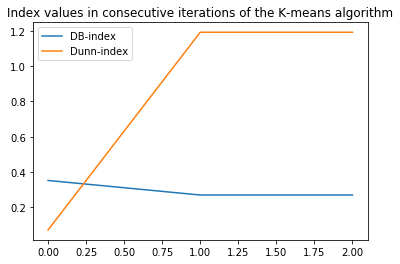

1.1916532768893362


In [6]:
centroids, cluster_table, cost_values_db, cost_values_dunn = k_means_clustering(3,X)
print(centroids)
#print(cluster_table)
print(cost_values_db)
plt.plot(cost_values_db)
plt.plot(cost_values_dunn)
plt.legend(['DB-index','Dunn-index'])
plt.title("Index values in consecutive iterations of the K-means algorithm")
plt.show()

print(cost_values_dunn[-1])

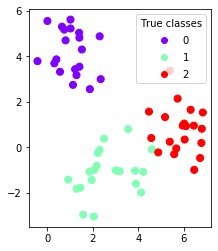

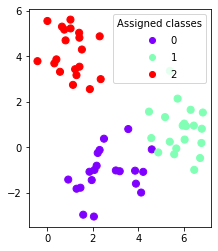

In [7]:
# Scatter plot - ORIGINAL
fig,ax = plt.subplots()
plt.axes().set_aspect('equal')
scatter=plt.scatter(X[:, 0], X[:, 1], c=y, s=50 , cmap='rainbow');
# produce a legend with the unique colors from the scatter
legend1 = plt.legend(*scatter.legend_elements(),
                    loc="upper right", title="True classes")
plt.show()

# Scatter plot - K-MEANS
fig,ax = plt.subplots()
plt.axes().set_aspect('equal')
scatter=plt.scatter(X[:, 0], X[:, 1], c=cluster_table[:,1], s=50 , cmap='rainbow');
# produce a legend with the unique colors from the scatter
legend1 = plt.legend(*scatter.legend_elements(),
                    loc="upper right", title="Assigned classes")
plt.show()

## Testing with the real benchmark data

## Testing with 2-dimensional data (Synthetic)

#### Reading in data

In [13]:
## Read in the data
synthetic = open("./Data/Synthetic.rtf").read()

## Transform the data into the format that our functions use

# Deleting the unnecessary parts of the text,
# which do not contain values
synthetic = synthetic[395:]
synthetic = synthetic.split("\\")

# Clean string values
synthetic = [w.replace('\n', '') for w in synthetic]
synthetic = [w.replace(' ', '') for w in synthetic]
synthetic = synthetic[:-1]

# Turn the strings into integer variables
synthetic_col1 = [int(w[:6]) for w in synthetic]
synthetic_col2 = [int(w[6:]) for w in synthetic]

# Check the length of the lists to see if method worked
print(len(synthetic_col1))
print(len(synthetic_col2))

# Convert the lists into numpy arrays and
synthetic = np.asarray((synthetic_col1,synthetic_col2))
synthetic = synthetic.T



print(synthetic.shape)
print(synthetic)

5000
5000
(5000, 2)
[[664159 550946]
 [665845 557965]
 [597173 575538]
 ...
 [650661 861267]
 [599647 858702]
 [684091 842566]]


0
[664159 665845 597173 ... 650661 599647 684091]
521210.1086


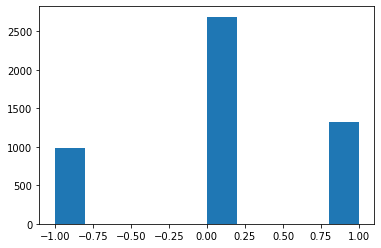

1
[550946 557965 575538 ... 861267 858702 842566]
490189.2928


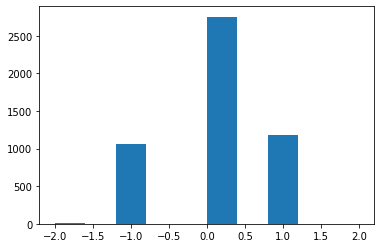

In [14]:
## Standardizing the data
for i in range(0,synthetic.shape[1]):
    
    temp_mean = np.mean(synthetic[:,i])
    synthetic[:,i] = synthetic[:,i] -  temp_mean
    
    temp_std = np.std(synthetic[:,i])
    synthetic[:,i] = synthetic[:,i]/temp_std
    
    plt.hist(synthetic[:,i])
    plt.show()

### K-means method

#### Running the K-means algorithm

In [4]:
X = synthetic[:1000,:]
centroids, cluster_table, cost_values_db, cost_values_dunn = k_means_clustering(15,X)

[383 522 601 391 142 864 574 577 592 184 814 109 441   8  26]


#### Calculating index values

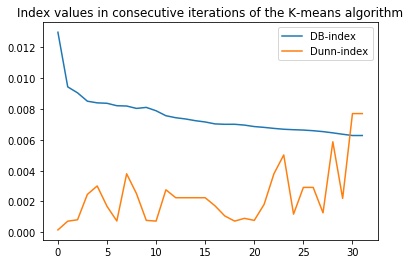

In [5]:
#print(centroids)
#print(cluster_table)
#print(cost_values_db)
plt.plot(cost_values_db)
plt.plot(cost_values_dunn)
plt.legend(['DB-index','Dunn-index'])
plt.title("Index values in consecutive iterations of the K-means algorithm")
plt.show()

#print(cost_values_dunn[-1])

#### Visualizing the clusters

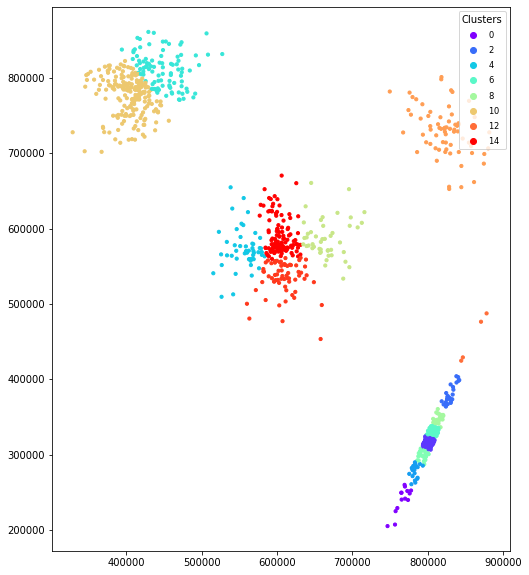

In [6]:
# Scatter plot - K-MEANS
fig,ax = plt.subplots(figsize=(10,10))
plt.axes().set_aspect('equal')

scatter=plt.scatter(X[:, 0], X[:, 1], c=cluster_table[:,1], s=10 , cmap='rainbow');

# Produce a legend with the unique colors for each cluster
legend1 = plt.legend(*scatter.legend_elements(),
                     fontsize = 'small',
                    loc="upper right", title="Clusters")


plt.show()

In [7]:
# Sanity-check for the clusters

c=cluster_table[:,1]
np.unique(c)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

### Minimum Spanning Tree clustering

#### Running the Kruskal-algorithm

In [10]:
result = mst_cluster(X,k=15,d=2)

Shape of X: (1000, 2)
Shape of sorted_vector: (499500, 3)
Shape of point_set: (1000, 3)
[0, 1]


#### Calculating index values

In [15]:
mst_centroids = centroid_calc_for_mst(K=15,d=2,result=result,X=X)
print(mst_centroids)

[[605803.66438356 573636.93150685]
 [526559.         509417.        ]
 [635586.5        660311.5       ]
 [712648.         607541.        ]
 [657985.         453405.        ]
 [695646.         652231.        ]
 [563460.         480559.        ]
 [659529.         498474.        ]
 [802415.36305732 319999.76751592]
 [874492.5        481861.        ]
 [418317.90705128 787462.96474359]
 [336958.5        715090.5       ]
 [822965.07575758 733563.45454545]
 [853112.5        658238.5       ]
 [828533.5        653917.5       ]]


In [28]:
## Calculate index values for MST
db_temp = DB_index(X,mst_centroids,result)
dunn_temp = dunn_index(X,mst_centroids,result)

print(db_temp)
print(dunn_temp)

0.0026136763519691254
0.03357066989188947


In [17]:
# Calculate index values for K-Means
print(cost_values_db[-1])
print(cost_values_dunn[-1])

0.006281978385699083
0.00770452060275991


#### Visualizing the clusters

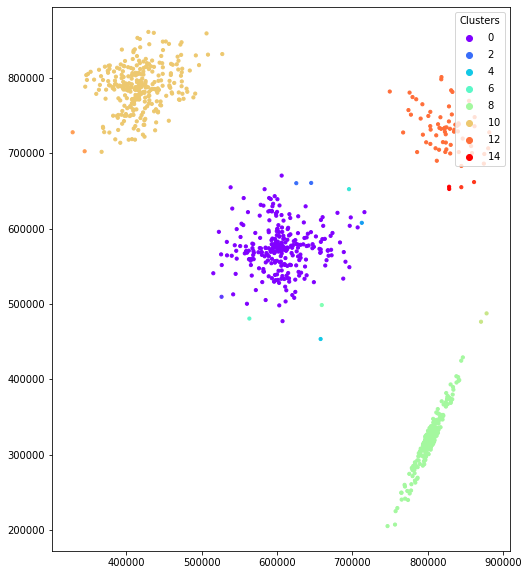

In [18]:
# Scatter plot - MST/Kruskal
fig,ax = plt.subplots(figsize=(10,10))
plt.axes().set_aspect('equal')
scatter=plt.scatter(X[:, 0], X[:, 1], c=result[:,1], s=10 , cmap='rainbow');
# produce a legend with the unique colors from the scatter
legend1 = plt.legend(*scatter.legend_elements(),
                    loc="upper right", title="Clusters")
plt.show()

### Comparing index values for K-means and MST

In [ ]:
### Comparing index values

## K-means
# Calculate index values for K-Means
db_kmeans = cost_values_db[-1]
dunn_kmeans = cost_values_dunn[-1]

## MST
# Calculate index values for MST
db_mst = DB_index(X,centroids,result)
dunn_mst = dunn_index(X,centroids,result)

print("The DB-index for K-means is {} and for MST it is {}".format(db_kmeans,db_mst))
print("The Dunn-index for K-means is {} and for MST it is {}".format(dunn_kmeans,dunn_mst))

### Optimizing over K (number of hypothetical clusters)

In this section we check whether our functions can recover that for the Synthetic dataset 15 clusters is the best (best index values). IF this is true, we can have confidence that repeating the same procedure will help us to find the optimal, but a priori unknown number of clusters in the Thyroid dataset.

[658 198 550 443 677 937 781 987 492 720 565 289]
[858 113 879 659 383 233 338 868 289 351 480   0 368]
[930 203 742 475  93 499 967 295 883 101  87 163 748 677]
[ 54 355 615 766 225 122 896  83 649 419 143  66 823  51 595]
[162 422 940 181 278 980 496 156 674 582 784 392 290 291 607 611]


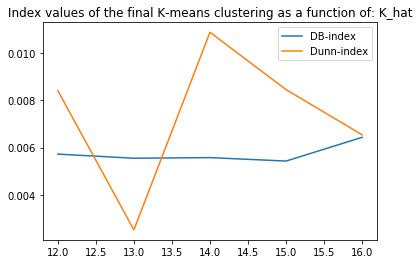

In [42]:
index_params_plotter('K_hat',12,17,X)

## Testing with 5 dimensional data (Thyroid)

#### Reading in data

In [15]:
## Read in the data
thyroid = pd.read_csv('./Data/Thyroid_new.csv', header=None)
print(thyroid.head())
print(thyroid.shape)

         0        1        2        3        4
0  3195023  3455331  3497964  3068822  3206710
1  3651455  3412754  4131996  3248619  3603214
2  4716462  4051411  3638860  3150548  2946503
3  3347167  2433481  3075276  3150548  3058020
4  3042879  2859252  3004828  3166893  2859768
(215, 5)


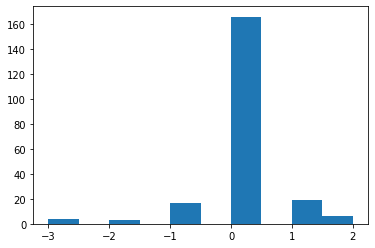

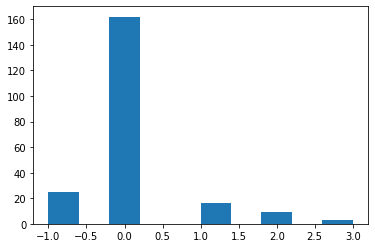

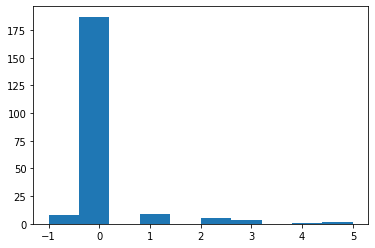

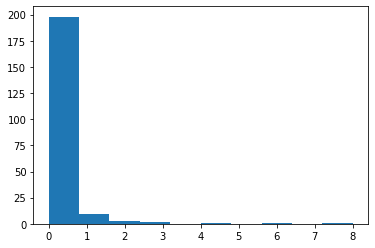

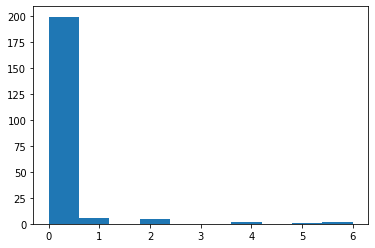

In [16]:
X_5d = np.array(thyroid)

## Standardizing the data
for i in range(0,X_5d.shape[1]):
    
    temp_mean = np.mean(X_5d[:,i])
    X_5d[:,i] = X_5d[:,i] -  temp_mean
    
    temp_std = np.std(X_5d[:,i])
    X_5d[:,i] = X_5d[:,i]/temp_std
    
    plt.hist(X_5d[:,i])
    plt.show()

### K-means method

#### Running the k-means algorithm

In [29]:
#X_5d = np.array(thyroid)
print(X_5d.shape)
centroids, cluster_table, cost_values_db, cost_values_dunn = k_means_clustering(3,X_5d)

(215, 5)
[113  96  75]


#### Optimizing over K (number of hypothetical clusters)

{'K_hat': 2}
[  8 133]
{'K_hat': 3}
[10 89 18]
{'K_hat': 4}
[193 172 183  21]
{'K_hat': 5}
[142  21  51 167  48]
{'K_hat': 6}
[162  66 114 141 154  13]
{'K_hat': 7}
[168 170 156 116 165 198 161]
{'K_hat': 8}
[ 20  46 214 146 155  19 107 113]
{'K_hat': 9}
[139  53  29 158  70 150  23 144 154]
{'K_hat': 10}
[148 195  63 139 199 148 151 189  61 131]
{'K_hat': 11}
[ 58  31 146 180  38 174 154 107  47 140 187]
{'K_hat': 12}
[208  46 149 149 136 133 212 164 167  86 108 212]
{'K_hat': 13}
[145 167 142 140  90  88  38 185 117  65  25  76 142]
{'K_hat': 14}
[ 71  39 144 157  57  79 205 175  48  89 205 175  50  66]


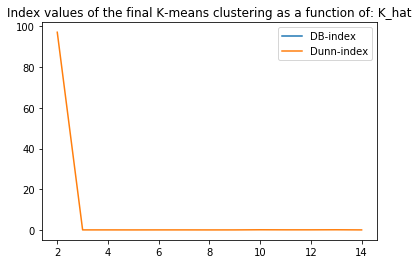

In [41]:
index_params_plotter(param = 'K_hat',start_value = 2,end_value = 15,X = X_5d)

#### Fitting the optimal model

In [22]:
centroids, cluster_table, cost_values_db, cost_values_dunn = k_means_clustering(3,X_5d)

[ 13  91 166]


#### Calculating the index values

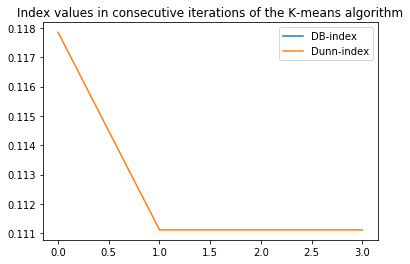

[nan, nan, nan, nan]


In [24]:
#print(centroids)
#print(cluster_table)
#print(cost_values_db)
plt.plot(cost_values_db)
plt.plot(cost_values_dunn)
plt.legend(['DB-index','Dunn-index'])
plt.title("Index values in consecutive iterations of the K-means algorithm")
plt.show()

print(cost_values_db)

### Minimum Spanning Tree clustering

#### Running the Kruskal algorithm

In [25]:
result_5d = mst_cluster(X_5d,k=3,d=5) # Using the optimised number of clusters from k-means

#### Optimizing over K (number of hypothetical clusters)

In [35]:
mst_index_params_plotter(param = 'K_hat',start_value = 2,end_value = 15,X=X_5d)

{'K_hat': 2}
{'K_hat': 3}


KeyboardInterrupt: 

Based on this analysis the optimal number of clusters is 2 or maybe 11, so MST finds a different optimum than K-means (which found 3 as the best number of clusters for MST.

#### Calculating the index values

In [26]:
mst_centroids_5d = centroid_calc_for_mst(K=3,d=5, result=result_5d, X=X_5d)
print(mst_centroids_5d)

## Calculate index values for MST
db_temp = DB_index(X_5d,mst_centroids_5d,result_5d)
dunn_temp = dunn_index(X_5d,mst_centroids_5d,result_5d)

print(db_temp)
print(dunn_temp)

[[-0.02369668  0.09952607  0.16113744  0.10900474  0.12796209]
 [ 0.5        -0.5         0.          1.          5.5       ]
 [ 0.         -1.          0.          7.          1.5       ]]
0.32176225829538313
0.1111111111111111


### Comparing index values for K-means and MST

In [27]:
### Comparing index values

## K-means
# Calculate index values for K-Means
db_kmeans = cost_values_db[-1]
dunn_kmeans = cost_values_dunn[-1]

## MST
# Calculate index values for MST
db_mst = DB_index(X_5d,mst_centroids_5d,result_5d)
dunn_mst = dunn_index(X_5d,mst_centroids_5d,result_5d)

print("The DB-index for K-means is {} and for MST it is {}".format(db_kmeans,db_mst))
print("The Dunn-index for K-means is {} and for MST it is {}".format(dunn_kmeans,dunn_mst))

The DB-index for K-means is nan and for MST it is 0.32176225829538313
The Dunn-index for K-means is 0.1111111111111111 and for MST it is 0.1111111111111111


## WIP (Work in Progress)

In [8]:
def index_params(n=300,p=2,K_true=3,std=0.9,K_hat=5):
    X, y = benchmark_data_generation(n=n,p=p,K=K_true,std = std)
    centroids, cluster_table, cost_values_db, cost_values_dunn = k_means_clustering(K_hat,X)
    db_final = cost_values_db[-1]
    dunn_final = cost_values_dunn[-1]
    
    return db_final,dunn_final

In [9]:

def index_params_plotter(param,start_value,end_value):
    dbs=[]
    dunns=[]
    integers = ['n','p','K_true','K_hat']
    floats = ['std']
    
    if param in integers:
        iterators = np.arange(start_value,end_value,1)
    else:
        iterators = np.arange(start_value,end_value,0.1)
        
    for i in iterators:
        #a = str(param)+'='+str(i)
        #print(type(a))
        temp_dict = {str(param) : i}
        #db_final,dunn_final = index_params(param=i)
        db_final,dunn_final = index_params(**temp_dict)
        # Use dictionary instead!!
        #db_final,dunn_final = index_params(K_hat=i)
        dbs.append(db_final)
        dunns.append(dunn_final)

    plt.plot(iterators,dbs)
    plt.plot(iterators,dunns)
    plt.legend(['DB-index','Dunn-index'])
    plt.title("Index values of the final K-means clustering as a function of: {}".format(param))
    plt.show()

[243   1]
[272 218 289]
[  0 199 228 116]
[171 263  58 253 109]


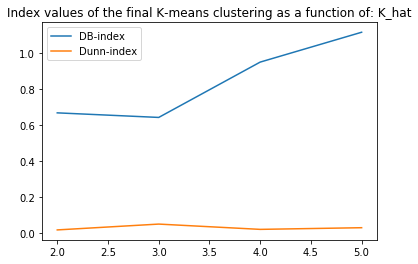

In [12]:
index_params_plotter(param='K_hat',start_value=2,end_value=6) # Algorithm should find 3 as optimal

## Support

In [3]:
# Test the custom function

x = np.array([1,2,3])
y = np.array([1,1,1])

print(euclidean_dist(x,y))

2.23606797749979


100
0.006729006703392466
      point_1  point_2  distance
3894     53.0     79.0  0.006729


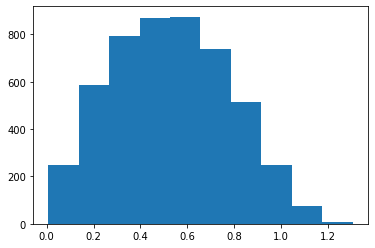

      index  point_1  point_2  distance
0      3770     50.0     96.0  1.305231
1      3743     50.0     69.0  1.265085
2       386      3.0     96.0  1.240727
3      2245     25.0     96.0  1.218423
4       359      3.0     69.0  1.205245
...     ...      ...      ...       ...
4945   1233     13.0     38.0  0.021243
4946   4047     57.0     58.0  0.018763
4947   1094     11.0     72.0  0.015639
4948   3586     47.0     62.0  0.015289
4949   3894     53.0     79.0  0.006729

[4950 rows x 4 columns]


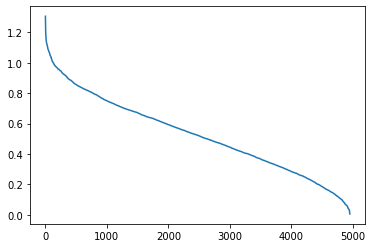

In [4]:
# Quick and dirty check for finding the 2 closest points

points = np.random.rand(100,2)

print(len(points))
#print(points)

results = np.random.rand(1,3)

for i in range(0,len(points)):
    for j in range(i+1,len(points)):
        dist = np.linalg.norm(points[i,:]-points[j,:])
        temp = np.array([i,j,dist]).reshape(1,3)
        #print(temp.shape)
        #print(results.shape)
        results = np.vstack((results,temp))

results = results[1:,:]        
#print(results)
print(min(results[:,2]))
a = min(results[:,2])


results = pd.DataFrame(results)
results.columns = ['point_1','point_2','distance']
#print(results.columns)

# Get the closest point
print(results[results['distance']<=a])


# Plot histogram of distance
plt.hist(results['distance'])
plt.show()

# Distance-sorted array
sorted_results = results.sort_values(by=['distance'],ascending=False).reset_index()
print(sorted_results)
plt.plot(sorted_results['distance'])
plt.show()

In [65]:
# Benchmark data generation
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=60, centers=5,n_features = 2,
                  random_state=0, cluster_std=0.2)

In [66]:
X = pd.DataFrame(X)
print(X.shape[0])

60


In [67]:
dist_matrix = np.zeros((len(y), len(y)))

In [68]:
for i in range(0,len(y)):
    for j in range(i+1,len(y)):
        dist_matrix[i,j]=euclidean_dist(np.array(X.iloc[i,]),np.array(X.iloc[j,]))

In [69]:
print(dist_matrix)

[[ 0.          0.32836797 14.35833286 ...  4.20854786  4.17960279
   5.30726092]
 [ 0.          0.         14.36333435 ...  4.30605762  4.25097055
   5.55465888]
 [ 0.          0.          0.         ... 10.34893277 10.2705343
  11.46289776]
 ...
 [ 0.          0.          0.         ...  0.          0.3515184
   2.87017855]
 [ 0.          0.          0.         ...  0.          0.
   3.22153427]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


In [70]:
temp = adjacency_matrix(X)
print(len(temp))

60


In [72]:
temp_vector = edge_vector(temp)
print(len(temp_vector))
print(temp_vector[21,:])

1770
[ 0.         22.          4.24637891]


In [73]:
sorted_list = edge_sorting(temp_vector)
print(len(sorted_list))

1770


In [74]:
# Parameters
K = 5 # Number of clusters
n = X.shape[0] # Number of observations
d = X.shape[1] # dimensions
X = np.array(X) # Convert pandas dataframe to numpy array

# STEP 0
# Get initial starting points
initial_indices = np.random.randint(0,high=n,size=K) # Initial indices
print(initial_indices)

centroids = np.zeros((K, d))

counter = 0
for i in initial_indices:
    centroids[counter,:] = X[i,:]
    counter += 1

print(centroids)

# STEP 1
# Assign points to centroids
cluster_table = np.zeros((n, 2))
cluster_table[:,0] = np.arange(0,n,1)
cluster_table = cluster_table.astype(int)

change_tracker = True
overall_change = 0
for i in range(0,n):
    current_cluster = int(cluster_table[i,1])
    #print(current_cluster)
    current_dist = euclidean_dist(X[i,],centroids[current_cluster,])
    for j in range(0,K):
        temp = euclidean_dist(X[i,],centroids[j,])
        if temp<current_dist:
            cluster_table[i,1]=j
            current_dist = temp
            
            overall_change += 1
            
if overall_change == 0:
    change_tracker = False

# STEP 2
# Recalculate centroids
print(cluster_table)

# Filter observations
temp_table = cluster_table[cluster_table[:,1]==0]
print(temp_table)

for i in range(0,K):
    # Filter for points in the given cluster
    temp_table2 = cluster_table[cluster_table[:,1]==i]
    
    # Calculating new centroids
    temp_array = np.zeros((len(temp_table2),d))
    counter = 0
    
    for j in temp_table2[:,0]:
        temp_array[counter,:] = X[j,:]
        counter += 1
    
    # Assign the new centroids
    centroids[i,:] = np.mean(temp_array, axis=0)
    

print(centroids)
print(overall_change)

[37 19  9 50 24]
[[ 0.98542178  4.26635056]
 [ 1.98568509  0.92893345]
 [-1.68953327  2.57262574]
 [-1.22287336  7.91585789]
 [ 9.646767   -2.14996069]]
[[ 0  3]
 [ 1  3]
 [ 2  4]
 [ 3  1]
 [ 4  2]
 [ 5  0]
 [ 6  3]
 [ 7  3]
 [ 8  4]
 [ 9  2]
 [10  0]
 [11  3]
 [12  1]
 [13  4]
 [14  1]
 [15  3]
 [16  1]
 [17  1]
 [18  1]
 [19  1]
 [20  4]
 [21  4]
 [22  0]
 [23  1]
 [24  4]
 [25  2]
 [26  3]
 [27  2]
 [28  1]
 [29  2]
 [30  2]
 [31  4]
 [32  0]
 [33  2]
 [34  4]
 [35  1]
 [36  0]
 [37  0]
 [38  1]
 [39  4]
 [40  4]
 [41  0]
 [42  0]
 [43  3]
 [44  3]
 [45  0]
 [46  4]
 [47  2]
 [48  4]
 [49  2]
 [50  3]
 [51  2]
 [52  1]
 [53  3]
 [54  0]
 [55  3]
 [56  2]
 [57  0]
 [58  0]
 [59  2]]
[[ 5  0]
 [10  0]
 [22  0]
 [32  0]
 [36  0]
 [37  0]
 [41  0]
 [42  0]
 [45  0]
 [54  0]
 [57  0]
 [58  0]]
[[ 1.05265327  4.28690396]
 [ 1.9385333   0.92517922]
 [-1.60284845  2.85541324]
 [-1.21824977  7.96700915]
 [ 9.3403589  -2.20695465]]
60


In [75]:
def k_means_clustering(K,X):
    n = X.shape[0] # Number of observations
    d = X.shape[1] # dimensions
    X = np.array(X) # Convert pandas dataframe to numpy array

    # STEP 0
    # Get initial starting points
    initial_indices = np.random.randint(0,high=n,size=K) # Initial indices
    print(initial_indices)

    centroids = np.zeros((K, d))

    counter = 0
    for i in initial_indices:
        centroids[counter,:] = X[i,:]
        counter += 1

    #print(centroids)

    # STEP 1
    # Assign points to centroids
    cluster_table = np.zeros((n, 2))
    cluster_table[:,0] = np.arange(0,n,1)
    cluster_table = cluster_table.astype(int)
    
    
    change_tracker = True
    
    # Big loop
    while change_tracker:
        overall_change = 0
        for i in range(0,n):
            current_cluster = int(cluster_table[i,1])
            #print(current_cluster)
            current_dist = euclidean_dist(X[i,],centroids[current_cluster,])
            for j in range(0,K):
                temp = euclidean_dist(X[i,],centroids[j,])
                if temp<current_dist:
                    cluster_table[i,1]=j
                    current_dist = temp

                    overall_change += 1

        if overall_change == 0:
            change_tracker = False

        # STEP 2
        # Recalculate centroids
        #print(cluster_table)

        # Filter observations
        temp_table = cluster_table[cluster_table[:,1]==0]
        #print(temp_table)

        for i in range(0,K):
            # Filter for points in the given cluster
            temp_table2 = cluster_table[cluster_table[:,1]==i]

            # Calculating new centroids
            temp_array = np.zeros((len(temp_table2),d))
            counter = 0

            for j in temp_table2[:,0]:
                temp_array[counter,:] = X[j,:]
                counter += 1

            # Assign the new centroids
            centroids[i,:] = np.mean(temp_array, axis=0)
            
    return centroids, cluster_table
    

In [29]:
# Distances
def within_cluster_dist(X,centroids,cluster_table):
    sums = []
    for i in range(0,len(centroids)):
        temp = cluster_table[cluster_table[:,1]==i]
        temp_sum = 0

        for j in range(0,len(temp)):
            index = temp[j,0]
            current_dist = euclidean_dist(X[index,],centroids[i,])
            temp_sum += current_dist

        temp_sum = math.sqrt(temp_sum/len(temp))

        sums.append(temp_sum)
        
    return sums

sums = within_cluster_dist(X,centroids,cluster_table)


print(sums)
        

[0.7261200296029495, 0.7964911256275813, 0.7725433034317905]


In [30]:
# Cluster separation
def cluster_separation(centroids):
    combinations = int(len(centroids)*(len(centroids)-1)/2)
    #print(combinations)
    separations = np.zeros((combinations,3))
    #print(separations)

    counter = 0
    for i in range(0, len(centroids)):
        for j in range(i+1, len(centroids)):
            separations[counter,0] = i
            separations[counter,1] = j
            separations[counter,2] = euclidean_dist(centroids[i,],centroids[j,])

            counter += 1
            
    return separations

separations = cluster_separation(centroids)
print(separations)

[[0.         1.         3.58825427]
 [0.         2.         4.10314712]
 [1.         2.         2.70287847]]


In [40]:
def DB_index(X,centroids,cluster_table):
    sums = within_cluster_dist(X,centroids,cluster_table)
    separations = cluster_separation(centroids)


    r_s = separations.copy()
    for i in range(0, len(r_s)):
        index_1 = int(r_s[i,0])
        index_2 = int(r_s[i,1])
        r_s[i,2] = (sums[index_1]+sums[index_2])/separations[i,2]

    d = []
    for j in range(0,len(centroids)):

        if j==0:
            temp1 = r_s[r_s[:,0]==j]
            max1 = max(temp1[:,2])
            d.append(max1)
        elif j==len(centroids)-1:
            temp2 = r_s[r_s[:,1]==j]
            max2 = max(temp2[:,2])
            d.append(max2)
        else:
            temp1 = r_s[r_s[:,0]==j]
            max1 = max(temp1[:,2])
            temp2 = r_s[r_s[:,1]==j]
            max2 = max(temp2[:,2])
            final_max = max(max1,max2)
            d.append(final_max)
            
    DB_index_val = sum(d)/len(centroids)
    
    return DB_index_val
    
#print(r_s[:,2])
index_val = DB_index(X,centroids,cluster_table)
print(DB_index(X,centroids,cluster_table))

0.5284473281063405


In [8]:
def max_within_distances(X,centroids,cluster_table):

    max_within_distances = []
    for k in range(0,len(centroids)):
        temp_table = cluster_table[cluster_table[:,1]==k]
        temp_max = 0
        for i in range(0,len(temp_table)):
            for j in range(i+1,len(temp_table)):
                index_1 = temp_table[i,0]
                index_2 = temp_table[j,0]
                current_value = euclidean_dist(X[index_1,],X[index_2,])
                if current_value>temp_max:
                    temp_max = current_value

        max_within_distances.append(temp_max)
        
    return max_within_distances

max_within_distances_temp = max_within_distances(X,centroids,cluster_table)


print(max_within_distances_temp)
            
    

[4.683398513150224, 4.962282131831923, 5.0739966333773925]


In [10]:
def min_between_distances(X,centroids,cluster_table):

    combinations = int(len(centroids)*(len(centroids)-1)/2)
    separations = np.zeros((combinations,3))

    counter = 0
    for i in range(0, len(centroids)):
        for j in range(i+1, len(centroids)):
            separations[counter,0] = i
            separations[counter,1] = j

            temp_table1 = cluster_table[cluster_table[:,1]==i]
            temp_table2 = cluster_table[cluster_table[:,1]==j]
            index_1 = temp_table1[1,0]
            index_2 = temp_table2[1,0]
            temp_min = euclidean_dist(X[index_1,],X[index_2,])
            for l in range(0,len(temp_table1)):
                for h in range(0,len(temp_table2)):
                    index_1 = temp_table1[l,0]
                    index_2 = temp_table2[h,0]
                    current_value = euclidean_dist(X[index_1,],X[index_2,])
                    if current_value<temp_min:
                        temp_min = current_value



            separations[counter,2] = temp_min

            counter += 1
            
    return separations

separations_temp = min_between_distances(X,centroids,cluster_table)    
print(separations_temp)

[[0.         1.         1.09459939]
 [0.         2.         1.4053912 ]
 [1.         2.         0.75837889]]


In [12]:
def dunn_index(X,centroids,cluster_table):
    separations_temp = min_between_distances(X,centroids,cluster_table)
    max_within_distances_temp = max_within_distances(X,centroids,cluster_table)
    
    result = min(separations_temp[:,2])/max(max_within_distances_temp)
    
    return result

dunn_temp = dunn_index(X,centroids,cluster_table)
print(dunn_temp)

0.14946381328503244


In [25]:
#### NOT USED CURRENTLY!

# Assign the new centroids
K = 15
d = 2

#points_set['Cluster'].nunique()
uniques = pd.DataFrame(result).iloc[:,1]
uniques = uniques.unique()
print(uniques)

# Get where the current cluster value is
index = int(result[0,1])
index = 274
#index = uniques[index]
unique_places = np.array([i==index for i in uniques])
temp = np.where(unique_places)[0]
print(temp)

indexer = 0

# Loop over the clusters table and assign cluster names
# going from 0-15 (basically just renaming clusters for convenience)
for i in range(0,len(result)):
    # Getting the current cluster label
    index = int(result[i,1]) 
    # Searching the current cluster label in the list of unique labels
    unique_places = np.array([i==index for i in uniques])
    
    # Assign the relative location of the current label to the range of 0-15
    temp = np.where(unique_places)[0]
    result[i,1] = temp

# Initialize the centroids to be 0
centroids2 = np.zeros((K, d))

for i in range(0,K):
            # Filter for points in the given cluster
            temp_table2 = result[result[:,1]==i]

            # Calculating new centroids
            temp_array = np.zeros((len(temp_table2),d))
            counter = 0

            for j in temp_table2[:,0]:
                temp_array[counter,:] = X[j,:]
                counter += 1

            # Assign the new centroids - coordinate-wise mean of points in the cluster
            centroids2[i,:] = np.mean(temp_array, axis=0)
            
#print(centroids2)


def centroid_calc_for_mst(K,d,result,X):
    """Calculates the centroids of the clusters
    found by the MST method"""
    
    # Get current unique labels
    uniques = pd.DataFrame(result).iloc[:,1]
    uniques = uniques.unique()
    
    # Loop over the clusters table and assign cluster names
    # going from 0-15 (basically just renaming clusters for convenience)
    for i in range(0,len(result)):
        # Getting the current cluster label
        index = int(result[i,1]) 
        # Searching the current cluster label in the list of unique labels
        unique_places = np.array([i==index for i in uniques])

        # Assign the relative location of the current label to the range of 0-15
        temp = np.where(unique_places)[0]
        result[i,1] = temp

    # Initialize the centroids to be 0
    centroids2 = np.zeros((K, d))

    for i in range(0,K):
                # Filter for points in the given cluster
                temp_table2 = result[result[:,1]==i]

                # Calculating new centroids
                temp_array = np.zeros((len(temp_table2),d))
                counter = 0

                for j in temp_table2[:,0]:
                    temp_array[counter,:] = X[j,:]
                    counter += 1

                # Assign the new centroids - coordinate-wise mean of points in the cluster
                centroids2[i,:] = np.mean(temp_array, axis=0)

    return centroids2


mst_centroids = centroid_calc_for_mst(K,d,result,X)
print(mst_centroids)

[  0   2  52  60   3  83  23 101 130 155 191  33  45 100 274]
[14]
[[605551.17948718 572681.6996337 ]
 [545382.2        607141.2       ]
 [534267.5        511028.        ]
 [688015.         533535.        ]
 [598545.66666667 493389.66666667]
 [625820.66666667 663622.        ]
 [670503.5        617924.5       ]
 [705449.66666667 604209.33333333]
 [538571.         654649.        ]
 [657985.         453405.        ]
 [695646.         652231.        ]
 [563460.         480559.        ]
 [522993.         595581.        ]
 [707049.         618211.        ]
 [659529.         498474.        ]]
